In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sp500 = pd.read_csv("/Users/douglasallen/Library/CloudStorage/GoogleDrive-deallen1989@gmail.com/My Drive/Northeastern/Machine Learning/Final/Raw Data/SP500.csv")

In [2]:
days_to_predict = 20

In [3]:
print("First 10 Days of S&P500 Data\n", sp500.head(10))

First 10 Days of S&P500 Data
         Date     Open     High      Low   Close*  Adj Close**      Volume
0   2-Nov-22  3852.90  3894.44  3758.68  3759.69      3759.69  4899000000
1   1-Nov-22  3901.79  3911.79  3843.80  3856.10      3856.10  4481210000
2  31-Oct-22  3881.85  3893.73  3863.18  3871.98      3871.98  4820620000
3  28-Oct-22  3808.26  3905.42  3808.26  3901.06      3901.06  4459410000
4  27-Oct-22  3834.69  3859.95  3803.79  3807.30      3807.30  4687320000
5  26-Oct-22  3825.97  3886.15  3824.07  3830.60      3830.60  4817310000
6  25-Oct-22  3799.44  3862.85  3799.44  3859.11      3859.11  4843120000
7  24-Oct-22  3762.01  3810.74  3741.65  3797.34      3797.34  4747930000
8  21-Oct-22  3657.10  3757.89  3647.42  3752.75      3752.75  5078020000
9  20-Oct-22  3689.05  3736.00  3656.44  3665.78      3665.78  4496620000


Convert Date column to pandas datetime object, trim data to Jan 1 2022 and onward, and make chronological

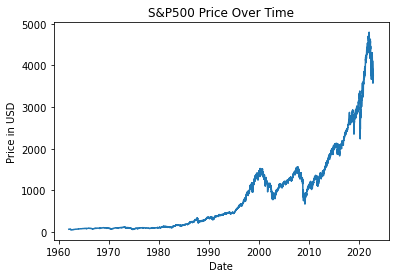

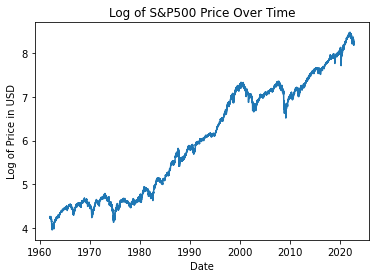

        Date     Open     High      Low   Close*  Adj Close**      Volume  \
0  11-Dec-20  3656.08  3665.91  3633.40  3663.46      3663.46  4367150000   
1  14-Dec-20  3675.27  3697.61  3645.84  3647.49      3647.49  4594920000   
2  15-Dec-20  3666.41  3695.29  3659.62  3694.62      3694.62  4360280000   
3  16-Dec-20  3696.25  3711.27  3688.57  3701.17      3701.17  4056950000   
4  17-Dec-20  3713.65  3725.12  3710.87  3722.48      3722.48  4184930000   

    DateTime  
0 2020-12-11  
1 2020-12-14  
2 2020-12-15  
3 2020-12-16  
4 2020-12-17  


In [4]:
sp500['DateTime'] = pd.to_datetime(sp500['Date'])
sp500['DateTime'] = np.where(sp500['DateTime'].dt.year > 2022, sp500['DateTime'] - pd.offsets.DateOffset(years=100), sp500['DateTime'])
# Anything after 2022 is changed to have 100 years subtracted because 2022 is the current year, change it as the years progress
plt.plot(sp500['DateTime'].loc[sp500['DateTime']>='1962-01-01'],sp500['Adj Close**'].loc[sp500['DateTime']>='1962-01-01'])
plt.title("S&P500 Price Over Time")
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.show()

plt.plot(sp500['DateTime'].loc[sp500['DateTime']>='1962-01-01'],np.log(sp500['Adj Close**'].loc[sp500['DateTime']>='1962-01-01']))
plt.title("Log of S&P500 Price Over Time")
plt.xlabel('Date')
plt.ylabel('Log of Price in USD')
plt.show()

end_date = pd.to_datetime('2021-12-31')
start_date = end_date - pd.offsets.DateOffset(days = days_to_predict)-pd.offsets.DateOffset(years = 1)

sp500 = sp500.loc[(sp500['DateTime']>=start_date)&(sp500['DateTime']<=end_date)]
sp500 = sp500.loc[::-1].reset_index(drop=True)
print(sp500.head())


Perform Log Return Transformation

Transform price into log price for time series fitting

In [5]:
sp500['log_price'] = np.log(sp500['Adj Close**'])

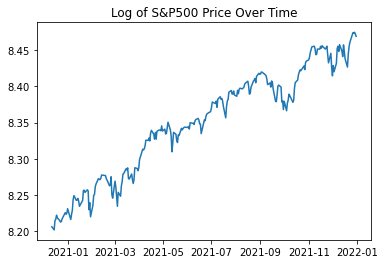

In [6]:
plt.plot(sp500['DateTime'],sp500['log_price'])
plt.title("Log of S&P500 Price Over Time")
plt.show()

Residuals are centered at 0 but not independent from time - there is periodicity

[0.00092334]


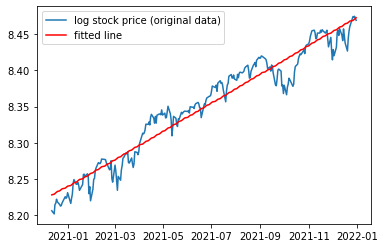

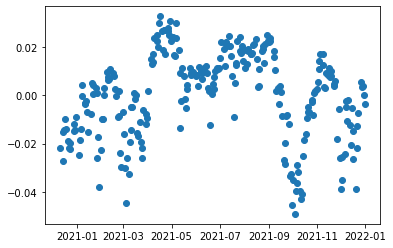

In [7]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = sp500.reset_index().index.values.reshape(-1,1)

clf.fit(index, sp500['log_price'])
print(clf.coef_) # To print the coefficient estimate of the series. 
linear_prediction = clf.predict(index)
plt.plot(sp500['DateTime'], sp500['log_price'], label='log stock price (original data)')
plt.plot(sp500['DateTime'], linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = sp500['log_price'] - linear_prediction
plt.plot(sp500['DateTime'], linear_residuals, 'o')
plt.show();

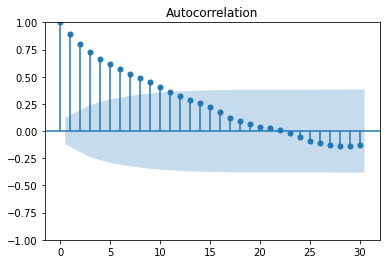

/Users/douglasallen/opt/anaconda3/envs/6.86x/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


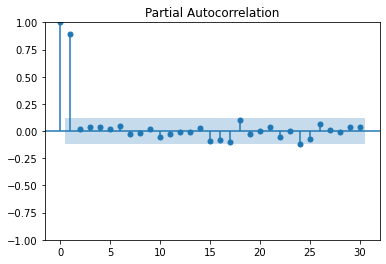

In [8]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(linear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=30)
plt.show()

                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  246
Model:                ARIMA(1, 0, 10)   Log Likelihood                 848.159
Date:                Mon, 12 Dec 2022   AIC                          -1670.317
Time:                        20:31:59   BIC                          -1624.748
Sample:                             0   HQIC                         -1651.969
                                - 246                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.006     -0.157      0.875      -0.014       0.012
ar.L1          0.8741      0.086     10.221      0.000       0.706       1.042
ma.L1         -0.0054      0.100     -0.053      0.9

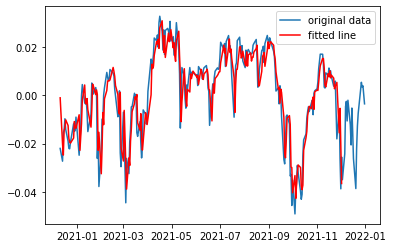

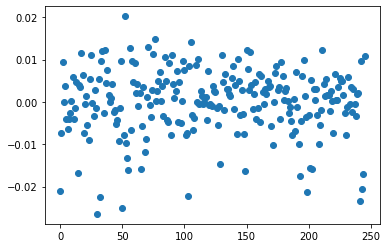

MSE with AR(1) model: 6.0310147893956044e-05


In [9]:
from statsmodels.tsa.arima.model import ARIMA
AR_order = 1
AR_differentiation = 0
MA_order = 10

days_to_predict = 20
training_days = sp500.iloc[0:sp500.shape[0]-days_to_predict]['DateTime']
train_residuals = linear_residuals.iloc[0:sp500.shape[0]-days_to_predict]
sp500_arima = ARIMA(train_residuals, order=(AR_order, AR_differentiation, MA_order)).fit()
print(sp500_arima.summary())
ar_higher_predictions = sp500_arima.predict()
ar_higher_residuals = train_residuals - ar_higher_predictions
ar_higher_residuals = ar_higher_residuals # Fitting AR 1 model means removing one observation
plt.plot(sp500['DateTime'],linear_residuals, label='original data')
plt.plot(training_days,ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_higher_residuals**2))


In [10]:
fcast = sp500_arima.get_forecast(days_to_predict).summary_frame()
forecast_means = fcast['mean']

train_and_predict = pd.concat([train_residuals,forecast_means])

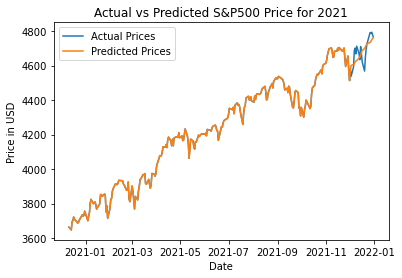

In [11]:
actual_prices = np.exp(linear_prediction+linear_residuals)
predicted_prices = np.exp(linear_prediction+train_and_predict)
plt.plot(sp500['DateTime'],actual_prices,label = 'Actual Prices')
plt.plot(sp500['DateTime'],predicted_prices,label = 'Predicted Prices')
plt.legend()
plt.title('Actual vs Predicted S&P500 Price for 2021')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.show()

In [12]:
yhat = np.exp(linear_prediction[-days_to_predict:]+forecast_means)
yhat = yhat.to_numpy()
y = sp500['Adj Close**'].to_numpy()[-days_to_predict:]

MAPE = 1/days_to_predict*np.sum(np.abs((yhat-y)/y))
RMSE = np.sqrt(1/days_to_predict*np.sum(np.linalg.norm(yhat-y)**2))
ET = np.abs(yhat[-1]-y[-1])

print(MAPE)
print(RMSE)
print(ET)


0.009707873959604244
55.53105454255407
3.3242175895347827


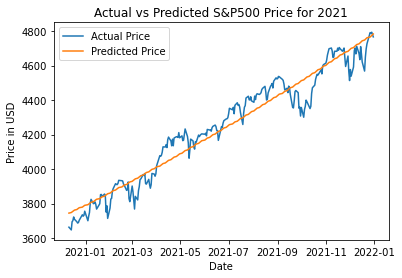

In [13]:
trivial_predict = np.exp(linear_prediction)
plt.plot(sp500['DateTime'],sp500['Adj Close**'],label = 'Actual Price')
plt.plot(sp500['DateTime'],trivial_predict,label='Predicted Price')
plt.legend()
plt.title('Actual vs Predicted S&P500 Price for 2021')
plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.show()

In [16]:
yhat_trivial = np.exp(linear_prediction[-days_to_predict:])


MAPE_triv = 1/days_to_predict*np.sum(np.abs((yhat_trivial-y)/y))
RMSE_triv = np.sqrt(1/days_to_predict*np.sum(np.linalg.norm(yhat_trivial-y)**2))
ET_triv = np.abs(yhat_trivial[-1]-y[-1])

print(MAPE_triv)
print(RMSE_triv)
print(ET_triv)


0.012890588581661908
78.85305527210055
16.81732682882921
